In [1]:
# Import some of the basis required functions
import pandas as pd
import numpy as np
from scipy.stats import norm
from joblib import Parallel, delayed
import networkx as nx
from scipy.stats import norm
import scipy as sp
import matplotlib.pyplot as plt
import ffn 
from matplotlib import collections as matcoll


In [2]:
startprice = ffn.get('^GSPC:Close', start='2020-08-31',end='2020-08-31').values[0][0]

<h3>Monte Carlo Simulation</h3>

In [3]:
# Exercise 1: Monte Carlo Simulation
class MonteCarlo():
    def __init__(self,sigma = None, rf = None, K = 3300):
        # If we do not call the function with a value, 
        # initialize at the "standard" numbers
        if rf==None:
            self.rf = (1+0.005/4)**4 - 1
        else:
            self.rf = rf
        if sigma == None:
            self.sigma = np.sqrt(12)*0.0428156
        else:
            self.sigma = sigma
        self.K     = K
        self.S0    = startprice
        np.random.seed(42)
        
    def propagate(self,Sn,dT):
        # We generate N(0,1) random variables
        # and multiply by sigma to get N(0,vola^2) variables
        phis = np.random.randn(len(Sn))
        return Sn + Sn * (self.rf*dT + self.sigma*np.sqrt(dT)*phis)
            
    def payout(self,prices,T,M):
        # Payout is price - strike IF larger than zero. Thus take max(0,S-K)
        payoff = np.max(np.vstack(((prices - self.K),
                                    np.zeros(len(prices)))),axis=0)
        # Discount by rf rate
        return np.exp(-1*self.rf * T)* np.mean(payoff)
    
    def simulate(self,M,N,T):
        dT = T/N
        # Start all at S0
        prices = np.ones(M) * self.S0
        # Iterate through N steps by the Euler equation
        for i in range(N):
            prices = self.propagate(prices,dT)
        # Get payout from these prices
        payout = self.payout(prices,T,M)
        return payout
    
    def stochastic_differential(self,M,T):
        # Solve the stochastic differential
        phis = np.random.randn(M)
        prices = self.S0 * np.exp((self.rf - 0.5*self.sigma**2)*T
                                  +self.sigma*np.sqrt(T)*phis)
        return prices
    
    def stochastic_payout(self,M,T):
        # Get M,T random price propagations
        prices = self.stochastic_differential(M,T)
        # For each, derive the payout max(0,S-K)
        payoff = np.max(np.vstack(((prices - self.K),
                                    np.zeros(len(prices)))),axis=0)
        return (np.exp(-1*self.rf * T))* np.mean(payoff)
    
    def black_scholes(self,T,call_put='call'):   
        # Simple Black Scholes equation. 
        S = self.S0
        K = self.K
        sigma = self.sigma
        r = self.rf
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0))
        self.BSprice = optionprice
        
    def plot_convergence(self,M_arr,values,M_many,values_many,title=None):
        # Plot the convergence given either one of the methods
        plt.figure()
        plt.scatter(M,values,color='red')
        plt.plot(M_many,values_many, color='black', label='Simulation',alpha=0.3)
        plt.ylabel('Option price at inception (USD)', size=13)
        plt.xlabel('Number of simulations', size=13)
        plt.scatter(250,233.8679716049668,label='Binomial Tree, N=250',color='purple',s=50)
        plt.axhline(self.BSprice, label='Black-Scholes limit',ls='dotted')
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()
        if title:
            plt.savefig(title)
        plt.tight_layout()

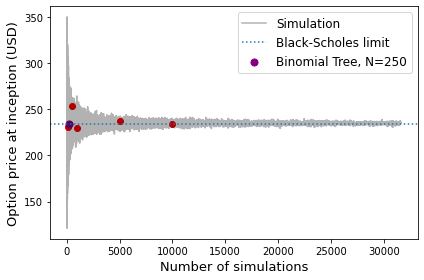

In [4]:
# Exercise a
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.simulate(w,3,0.25) for w in M]
M_many = np.logspace(1.5,4.5,25000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.simulate)(N,3,0.25) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many,title='1a_convergence.pdf')
# Plot marker for last week

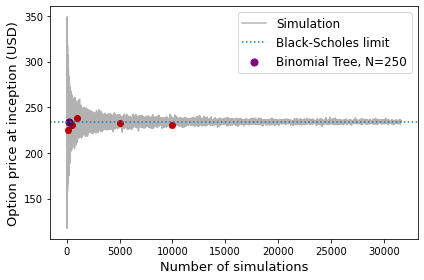

In [5]:
# Exercise b
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.simulate(w,63,0.25) for w in M]
M_many = np.logspace(1.5,4.5,25000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.simulate)(N,63,0.25) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many,title='1b_convergence.pdf')
# RMSE for deviation from Black Scholes

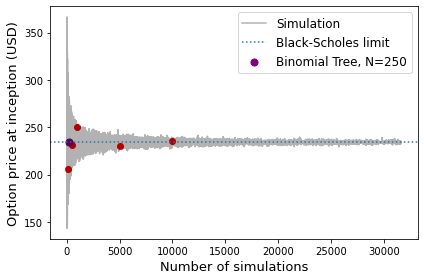

In [6]:
# Exercise c
MC = MonteCarlo()
M = np.array([100,500,1000,5000,10000])
call_values = [MC.stochastic_payout(w,0.25) for w in M]
M_many = np.logspace(1.5,4.5,25000,dtype=int)
call_values_many = Parallel(n_jobs=22)(delayed(MC.stochastic_payout)(N,0.25) for N in M_many)
MC.black_scholes(T=0.25)
MC.plot_convergence(M,call_values,M_many,call_values_many,title='1c_convergence.pdf')

In [146]:
def trailing_RMSE():
    # Note, will take long!
    
    # Get option price as function of number of simulations forthe three situations
    MC = MonteCarlo()
    MC.black_scholes(T=0.25)

    X = np.logspace(0.8,6,50000,dtype=int)
    Y_1 = Parallel(n_jobs=22)(delayed(MC.simulate)(N,3,0.25) for N in X)
    Y_2 = Parallel(n_jobs=22)(delayed(MC.simulate)(N,63,0.25) for N in X)
    Y_3 = Parallel(n_jobs=22)(delayed(MC.stochastic_payout)(N,0.25) for N in X)
    convergence_df = pd.DataFrame({'Nsims':X,'MonthlyEuler':Y_1,'DailyEuler':Y_2,'StochasticInt':Y_3}).set_index('Nsims')

    convergence_df['Error_MonthlyEuler']    = (convergence_df['MonthlyEuler']-MC.BSprice)**2
    convergence_df['Error_DailyEuler']      = (convergence_df['DailyEuler']-MC.BSprice)**2
    convergence_df['Error_StochasticInt']   = (convergence_df['StochasticInt']-MC.BSprice)**2
    convergence_df.to_pickle('convergence_df_ex1.pickle')
    return convergence_df
convergence_df = trailing_RMSE()

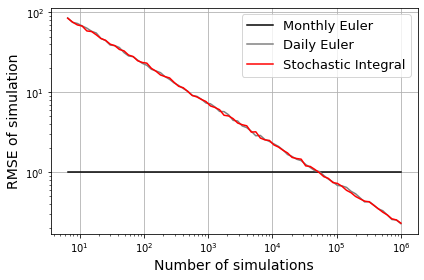

In [156]:
# Three lines of trailing RMSE
def plot_trailing_RMSE():
    X = convergence_df.index.values
    # Define bins
    total_bins = 75
    bins = np.logspace(np.log10(X.min()),np.log10(X.max()), total_bins)
    delta = bins[1]-bins[0]
    idx  = np.digitize(X,bins)
    
    # Get trailing RMSE (=sqrt(mean(simulationprice - BS price)**2)
    running_median_a = np.array([np.sqrt(np.mean(convergence_df['Error_MonthlyEuler'][idx==k])) for k in range(total_bins)])
    running_median_b = np.array([np.sqrt(np.mean(convergence_df['Error_DailyEuler'][idx==k])) for k in range(total_bins)])
    running_median_c = np.array([np.sqrt(np.mean(convergence_df['Error_StochasticInt'][idx==k])) for k in range(total_bins)])

    #running_median_a = running_median_a/running_median_a
    #running_median_b = running_median_b/running_median_a
    #running_median_c = running_median_c/running_median_a
    
    plt.plot(bins-delta/2,running_median_a,lw=1.5,color='black',label='Monthly Euler')
    plt.plot(bins-delta/2,running_median_b,lw=1.5,color='grey', label='Daily Euler')
    plt.plot(bins-delta/2,running_median_c,lw=1.5,color='red', label='Stochastic Integral')
    plt.semilogy()
    plt.semilogx()
    plt.grid()
    plt.ylabel('RMSE of simulation', size=14)
    plt.xlabel('Number of simulations', size=14)
    plt.legend(loc='best', fontsize=13)
    plt.tight_layout()
    plt.savefig('Convergence_compared_ex1.pdf')
    plt.show()
plot_trailing_RMSE()

<h3>Dynamic Hedging</h3>

In [25]:
class DynamicHedging():
    def __init__(self,S0,K,T,r,sigma,mu):
        # Initialize function by setting all attributes
            self.S0 = S0
            self.K  = K
            self.T  = T
            self.rf = r
            self.sigma = sigma
            self.mu = mu
            self.Ncontracts = 10
            self.npercontract = 100 # Options always have 100 underlying value
            
    def black_scholes(self,S,T,call_put='call'):   
        # Same Black scholes as before
        K = self.K
        sigma = self.sigma
        r = self.rf
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)

        if call_put == 'call':
            optionprice = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
        elif call_put == 'put':
            optionprice = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
        self.BSprice = optionprice   
        # Return dictionary with the optionprice and deltas, as we need these 
        return {'delta':norm.cdf(d1), 'optionprice':optionprice}
        
     
    def money_received(self,T,Ncontracts):
        self.black_scholes(self.S0,T)
        return self.npercontract * Ncontracts * self.BSprice
    
    def propagate(self,Sn,dT):
        phis = np.random.randn(len(Sn))
        # Propagate with mu and sigma (real world)
        return Sn + Sn * (self.mu*dT + self.sigma*np.sqrt(dT)*phis)

    def simulate_paths(self,M,N,T):
        # Generate prices for each timestep
        dT = T/N
        prices = np.ones((M,N)) * self.S0
        for i in range(N-1):
            prices[:,i+1] = self.propagate(prices[:,i],dT)
        return prices
    
    def plot_paths(self,M,N,T):
        prices = self.simulate_paths(M,N,T)
        weeks = np.arange(1,N+1)
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(weeks,prices[-1,:],color='black',lw=0.02,label='Simulations')
        ax.plot(weeks,prices.T,color='grey',lw=0.025)
        # Add label to one line, otherwise we need to remove 4999 legend markers
        ax.set_ylabel('Stock price (USD)', size=13)
        ax.set_xlabel('Number of weeks passed', size=13)
        ax.plot(weeks,prices.mean(axis=0),label='Trailing mean',color='red',ls='dotted')
        # inset axes for close up
        axins = ax.inset_axes([0.05, 0.05, 0.7, 0.25])
        axins.plot(weeks,prices.mean(axis=0),color='red',ls='dotted')
        # sub region of the original image
        x1, x2, y1, y2 = 0.8,13,3250,3400
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        axins.set_xticklabels('')
        axins.tick_params(axis="y",direction='in',pad=-35)

        axins.set_yticks([3280,3350])
        #axins.set_yticklabels('')
        ax.indicate_inset_zoom(axins,lw=1,alpha=0.8,edgecolor='black',label='')
        lgd = plt.legend(loc='upper left')
        for legobj in lgd.legendHandles:
            legobj.set_linewidth(1.0)
        ax.set_ylim(2400,4150)
        ax.set_rasterized(True)
        plt.tight_layout()   
        plt.savefig('Stockpaths.pdf')
        plt.show()
        return prices
    
    def hedging(self,T, N,callprice=None):
        # Iteratively determine deltas, cash and stock position
        # callprice contains "callprice" to find PNL in case of mispricing of call
        S = self.S0
        sigma = self.sigma
        strike = self.K
        rf = self.rf
        mu = self.mu

        # We start with zero cash
        cash = 0.0
        dt = T/N
        # We start with zero stock (delta)
        delta = 0.0
        # Get value and delta of BS call
        call = self.black_scholes(S,T)
        # We short a call and thus receive the BS call price
        if not callprice:
            cash = call['optionprice']
        else:
            cash = callprice
        for i in range(N):
            call = self.black_scholes(S,T)
            # Delta is how much we need to have form the stock to hedge
            # Subtract what we already have; what do we need to buy or sell
            ToBuySell = call['delta'] - delta    
            # Our cash position changes with what we buy / sell at price S
            cash -= ToBuySell*S
            # How much we own of the stock now
            delta = call['delta']
            #print ( "Timestep", i+1, "Stock price:", S, "Delta:", delta)
            #print ("Amount  for buying/selling" , ToBuySell)
            e = sp.random.normal(0,1)

            # Simulate stock price using mu and sigma
            S = S + S * (mu*dt + sigma*np.sqrt(dt)*e)
            # The time remaining decreases by dt
            T -= dt
            # We receive interest on the cash money
            cash *= np.exp(rf*dt)
        # Interest is not paid at the maturity of the option
        cash = cash / np.exp(rf*dt)                       
        PNL = cash+delta*S-max(0,S-strike)
        PNL_total = self.npercontract * self.Ncontracts * PNL
        return PNL_total
    
    def hedging_distr(self,T,N,plot=True,nsims = 10000,callprice=None):
        profit = np.array(Parallel(n_jobs=22)(delayed(self.hedging)(T,N,callprice) for iter_ in range(nsims)))
        
        if plot:
            plt.figure()
            plt.ylabel('Frequency', size=13)
            plt.xlabel('Profit (loss) (USD)', size=13)
            plt.xticks(rotation=-45)
            plt.hist(profit,bins=250)
            print(np.mean(profit))
        return np.nanmean(profit), np.nanstd(profit)
plt.show()

In [26]:
# Get value at inception using BS result
startingprice = 3300
strike        = 3300
T             = 0.25
r             = np.log((1+0.005/4)**4)#-1
sigma         = np.exp(np.sqrt(12)*0.0428156)-1
mu            = 0.04

In [27]:
DH = DynamicHedging(startingprice,strike,T,r,sigma,mu)
print('Amount received is ',DH.money_received(T,10))

Amount received is  107221.62695149223


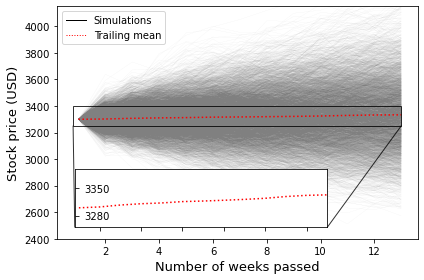

In [28]:
# Simulate paths for S&P
stockprices = DH.plot_paths(5000,13,13/52)
# Same for call option and hedging
# plot of deltas as function of time

In [29]:
# Need dynamic hedging using d1 values from BS result
# At each of the 13 timesteps we need to evaluate the value for N(d1)

870.0909492164874


(870.0909492164874, 48133.46455087855)

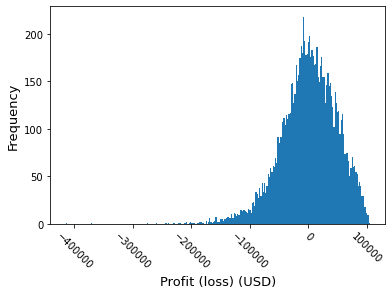

In [30]:
DH.hedging_distr(0.25,3,50000)

-4.411689340210753


11486.790349559722

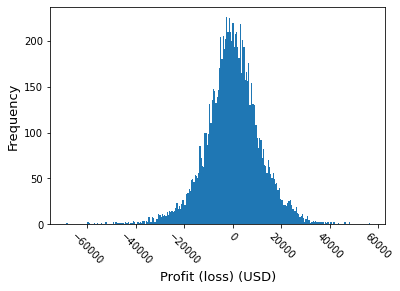

In [15]:
Ndays = int(0.25*252)
DH.hedging_distr(0.25,Ndays,500000)

-109.49926223617929


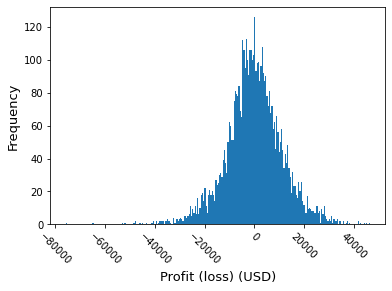

In [46]:
DH = DynamicHedging(startingprice,strike,T,r,sigma,0.08)
DH.hedging_distr(0.25,Ndays,5000)
# STD plus conf bound
# STD as function of mu

In [13]:
add_vola = sigma+0.05

-124.24185457361673


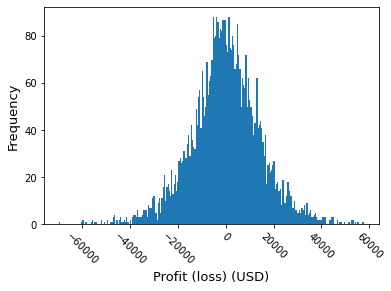

In [17]:
DH = DynamicHedging(startingprice,strike,T,r,add_vola,0.08)
DH.hedging_distr(0.25,Ndays,5000)
# STD plus conf bound
# STD as function of mu

In [56]:
class performance_evaluation():
    def __init__(self):
        """Class containing modules to test performance of the hedging"""
        return
    
    def std_worker(self,tup):
        """Worker for parallel implementation of STD evaluation"""
        mu,sigma = tup
        DH = DynamicHedging(startingprice,strike,T,r,sigma,mu)
        mean,std = DH.hedging_distr(0.25,3,plot=False,nsims=1000)
        print('done')
        return (mu,sigma,std)

    
    def STD_var(self,mus,sigmas):
        """Get for range of mu and sigma the std of PNL"""
        tuples = []
        for i in mus:
            for j in sigmas:
                tuples.append((i,j))
        results = Parallel(n_jobs=18)(delayed(self.std_worker)(tup) for tup in tuples)
        self.STD_results = results
        
    def plot_STD(self):
        """Plot 2D map of STD as function of mu and sigma"""
        mus = np.arange(0,1,0.01)
        sigmas = np.arange(0,1,0.01)
        self.STD_var(mus,sigmas)
        std = [w[2] for w in self.STD_results]
        
        z = np.nan_to_num(np.array(std).reshape(len(mus),len(sigmas)))
        from scipy.ndimage.filters import gaussian_filter
        filtered_arr=gaussian_filter(z, 3)
        plt.imshow(filtered_arr,cmap='gist_heat_r',extent=[sigmas.min(),sigmas.max(),mus.min(),mus.max()])
        plt.ylabel(r'$\mu$ (%)',size=14)
        plt.xlabel(r'$\sigma$ (%)',size=14)
        plt.tight_layout()
        plt.savefig('std_for_mu_sigms.pdf')
        
    def call_var(self):
        """Simulate the PNL for multiple situations of mispricing and get net PNL"""
        calls = np.linspace(10,300,5)
        results = Parallel(n_jobs=22)(delayed(self.mispricing_worker)(callprice) for callprice in calls)
        self.calls = calls
        self.mispricing_PNL = results
        
    def mispricing_worker(self,callprice):
        # Get value at inception using BS result
        r             = np.log((1+0.005/4)**4)#-1
        sigma         = np.exp(np.sqrt(12)*0.0428156)-1
        mu            = 0.04
        DH = DynamicHedging(S0=3300,K=3300,T=0.25,r=r,sigma=sigma,mu=mu)
        mean,std = DH.hedging_distr(0.25,3,plot=False,nsims=5000,callprice=callprice)
        return mean
    
    def plot_mispricing(self):
        """Plot PNL as function of call mispricing in the market"""
        self.call_var()
        
        plt.plot(self.calls,self.mispricing_PNL,label='PNL',color='black')
        plt.ylabel('Profil or loss (USD)',size=14)
        plt.xlabel('Market price for call option (USD)',size=14)
        plt.axhline(0,ls='dotted',color='grey',lw=2)
        plt.axvline(DH.BSprice,ls='dotted',color='red',lw=2,label='Black-Scholes price')
        plt.legend(fontsize=13)
        plt.grid()
        plt.tight_layout()
        plt.savefig('PNL_marketprice.pdf')

In [ ]:
PE = performance_evaluation()
PE.plot_STD()

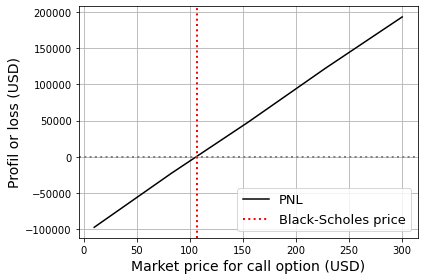

In [45]:
PE = performance_evaluation()
PE.plot_mispricing()